<a href="https://colab.research.google.com/github/danielfrgs/2022_1-Reconocimiento-Patrones/blob/main/Tareas/Tarea%206/k_means_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio: K-means con Sklearn

Fragoso Alvarado Daniel

## Agrupar usuarios Twitter de acuerdo a su personalidad con K-means

<p>Para la práctica se utilizará de entradas un conjunto de datos que se obtuvo de un proyecto propio, en el que se analiza rasgos de la personalidad de usuarios de Twitter. Se ha filtrado a 140 “famosos” del mundo en diferentes áreas: deporte, cantantes, actores, etc. Basado en una metodología de psicología conocida como “Ocean: The Big Five” se tiene como características de entrada:</p>

<ul>
    <li>usuario (el nombre en Twitter)</li>
    <li>“op” = Openness to experience – grado de apertura mental a nuevas experiencias, curiosidad, arte</li>
    <li>“co” = Conscientiousness – grado de orden, prolijidad, organización</li>
    <li>“ex” = Extraversion – grado de timidez, solitario o participación ante el grupo social</li>
    <li>“ag” = Agreeableness – grado de empatía con los demás, temperamento</li>
    <li>“ne” = Neuroticism, – grado de neuroticismo, nervioso, irritabilidad, seguridad en sí mismo.</li>
    <li>Wordcount – Cantidad promedio de palabras usadas en sus tweets</li>
    <li>Categoria – Actividad laboral del usuario (actor, cantante, etc.)</li>
</ul>
        
<p>Se utilizará el algoritmo K-means para que agrupe estos usuarios -no por su actividad laboral- si no, por sus similitudes en la personalidad. Sólo utilizaremos 3 columna en este ejemplo, de modo que podamos ver en un gráfico tridimensional -y sus proyecciones a 2D- los grupos resultantes. Pero para casos reales, podemos utilizar todas las dimensiones que necesitemos. Una de las hipótesis que podríamos tener es: “Todos los cantantes tendrán personalidad parecida” (y así con cada rubro laboral). Pues veremos si lo probamos, o por el contrario, los grupos no están relacionados necesariamente con la actividad de estas Celebridades.</p>

In [2]:
#Importando las librerías que nos asistirán para ejecutar el algoritmo y graficar.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
 
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

In [3]:
#Importar el archivo csv y vemos los primeros 5 registros del archivo tabulados.
dataframe = pd.read_csv("analisis.csv")
dataframe.head(5)

,usuario,op,co,ex,ag,ne,wordcount,categoria
0,3gerardpique,34.297953,28.148819,41.948819,29.370315,9.841575,37.0945,7
1,aguerosergiokun,44.986842,20.525865,37.938947,24.279098,10.362406,78.7970,7
2,albertochicote,41.733854,13.745417,38.999896,34.645521,8.836979,49.2604,4
3,AlejandroSanz,40.377154,15.377462,52.337538,31.082154,5.032231,80.4538,2
4,alfredocasero1,36.664677,19.642258,48.530806,31.138871,7.305968,47.0645,4


In [4]:
#También podemos ver una tabla de información estadística que nos provee Pandas dataframe
dataframe.describe()

,op,co,ex,ag,ne,wordcount,categoria
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
mean,44.414591,22.977135,40.764428,22.918528,8.000098,98.715484,4.050000
std,8.425723,5.816851,7.185246,7.657122,3.039248,44.714071,2.658839
min,30.020465,7.852756,18.693542,9.305985,1.030213,5.020800,1.000000
25%,38.206484,19.740299,36.095722,17.050993,6.086144,66.218475,2.000000
50%,44.507091,22.466718,41.457492,21.384554,7.839722,94.711400,3.500000
75%,49.365923,26.091606,45.197769,28.678866,9.758189,119.707925,7.000000
max,71.696129,49.637863,59.824844,40.583162,23.978462,217.183200,9.000000


<b>Pregunta 1: (30 puntos)</b> ¿Qué significa cada una de las estadísticas mostradas? Haga una pequeña explicación de cada una de ellas y utilice por cada una un valor como ejemplo para darle sentido a su explicación.

<b>Respuesta 1:</b>

<p>El archivo contiene diferenciadas 9 categorías -actividades laborales- que son:</p>
<ol>
    <li>Actor/actriz</li>
    <li>Cantante</li>
    <li>Modelo</li>
    <li>Tv, series</li>
    <li>Radio</li>
    <li>Tecnología</li>
    <li>Deportes</li>
    <li>Politica</li>
    <li>Escritor</li>
</ol>

In [5]:
#Para conocer cuántos registros tenemos de cada ponemos las siguientes lineas
print(dataframe.groupby('categoria').size())

# Como vemos tenemos 34 cantantes, 27 actores, 17 deportistas, 16 políticos,etc

categoria
1    27
2    34
3     9
4    19
5     4
6     8
7    17
8    16
9     6
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


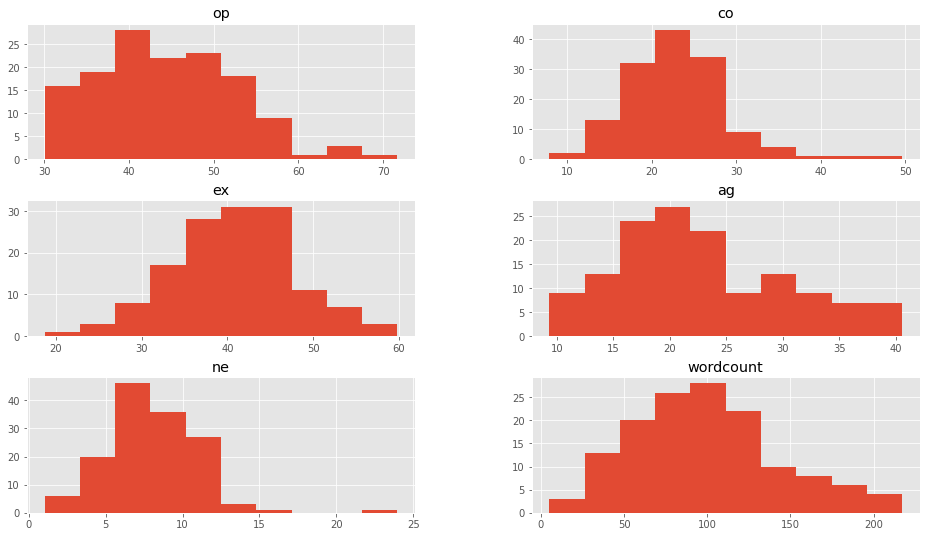

In [6]:
#Veremos graficamente nuestros datos para tener una idea de la dispersión de los mismos
dataframe.drop(['categoria'],1).hist()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


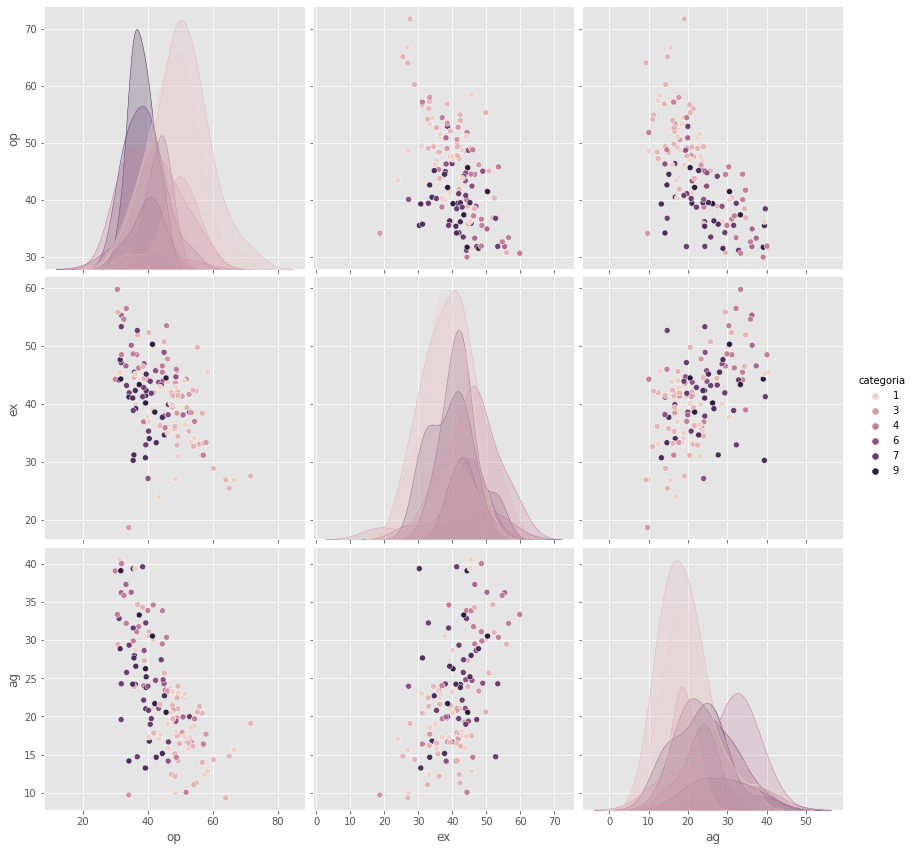

In [7]:
#En este caso seleccionamos 3 dimensiones: op, ex y ag 
#y las cruzamos para ver si nos dan alguna pista de su agrupación y la relación con sus categorías.
sb.pairplot(dataframe.dropna(), hue='categoria',size=4,vars=["op","ex","ag"],kind='scatter')

#Revisando la gráfica no pareciera que haya algún tipo de agrupación o correlación entre los usuarios y sus categorías

In [8]:
#Definimos la entrada
#Concretamos la estructura de datos que utilizaremos para alimentar el algoritmo.
#Sólo cargamos las columnas op, ex y ag en nuestra variable X.
X = np.array(dataframe[["op","ex","ag"]])
y = np.array(dataframe['categoria'])
X.shape

(140, 3)

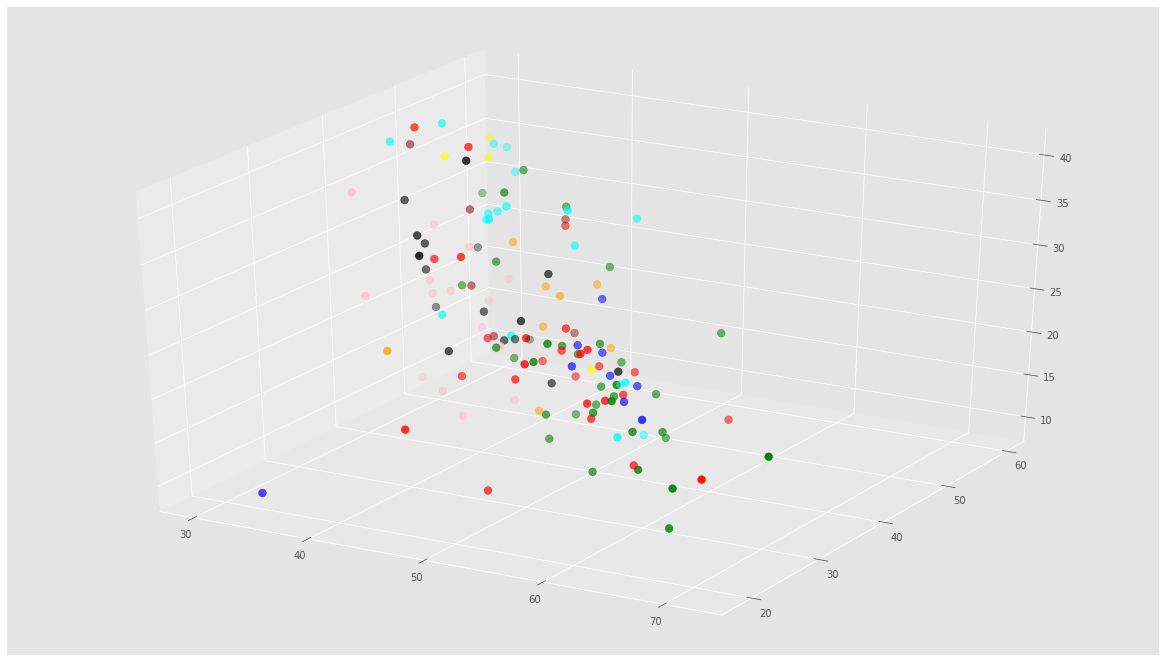

In [9]:
#Tenemos una gráfica en 3D con 9 colores representando las categorías.
fig = plt.figure()
ax = Axes3D(fig)
colores=['blue','red','green','blue','cyan','yellow','orange','black','pink','brown','purple']
asignar=[]
for row in y:
    asignar.append(colores[row])
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar,s=60)

#Veremos si con K-means, podemos “pintar” esta misma gráfica de otra manera, con clusters diferenciados.

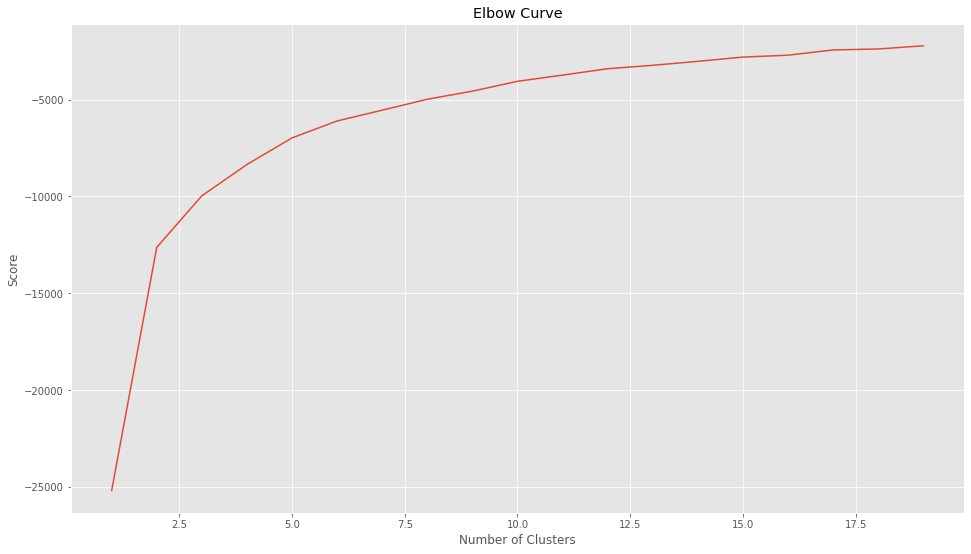

In [10]:
#Obtener el valor K
#Hallamos el valor de K haciendo una gráfica intentando hallar el “punto de codo”
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

#En la siguiente referencia ver una explicación del Método del codo para la selección del número correcto de clusters k
# https://www.jacobsoft.com.mx/es_mx/k-means-clustering-con-python/

<p>Realmente la curva es bastante “suave”. Se considera a 5 como un buen número para K.</p>

<b>Pregunta 2: (20 puntos)</b> Según su criterio, ¿cuál tomarías y por qué?

<b>Respuesta 2:</b>

In [11]:
#Ejecutamos K-Means
#Ejecutamos el algoritmo para 5 clusters y obtenemos las etiquetas y los centroids.
kmeans = KMeans(n_clusters=5).fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

[[58.58657531 31.02839375 15.6120435 ]
 [35.8763031  48.7473571  33.96090838]
 [49.99285115 40.87133549 17.47411785]
 [42.40604536 32.90654277 21.94949986]
 [39.30015109 43.66323625 24.20647012]]


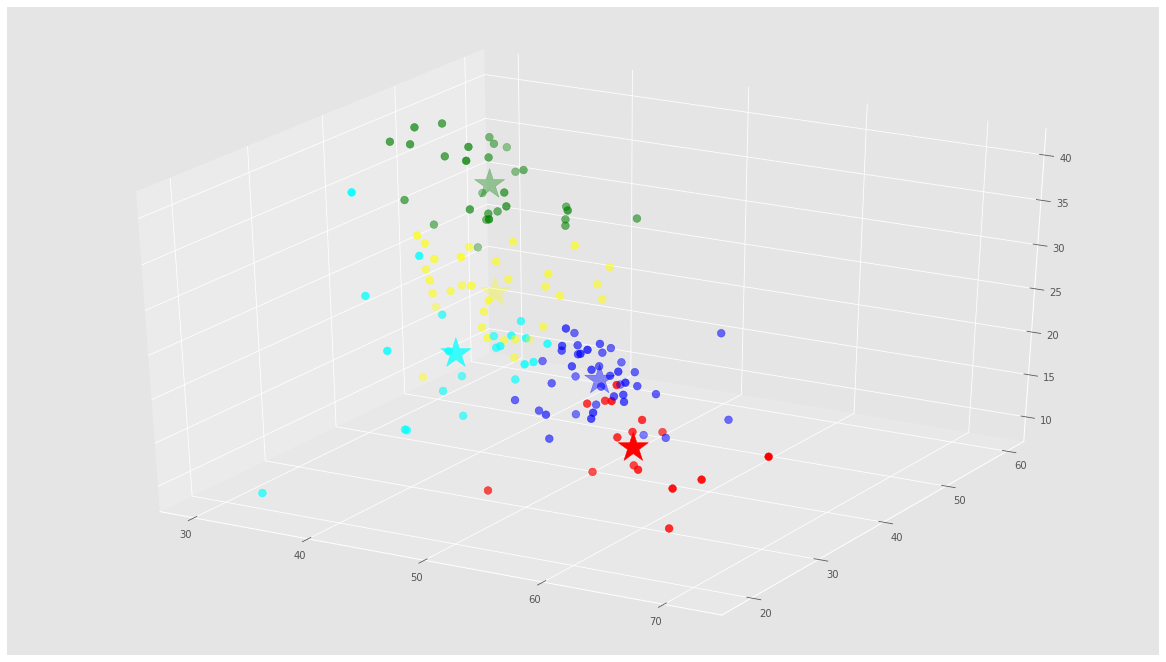

In [12]:
#Ahora se puede ver esto en una gráfica 3D con colores para los grupos y veremos si se diferencian:
# (las estrellas marcan el centro de cada cluster)

# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores = ['red','green','blue','cyan','yellow']
asignar = []
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)

#Podemos ver que el Algoritmo de K-Means con K=5 ha agrupado a los 140 usuarios Twitter por su personalidad,
# teniendo en cuenta las 3 dimensiones que utilizamos: Openess, Extraversion y Agreeablenes. 
#Pareciera que no hay necesariamente una relación en los grupos con sus actividades de Celebrity.

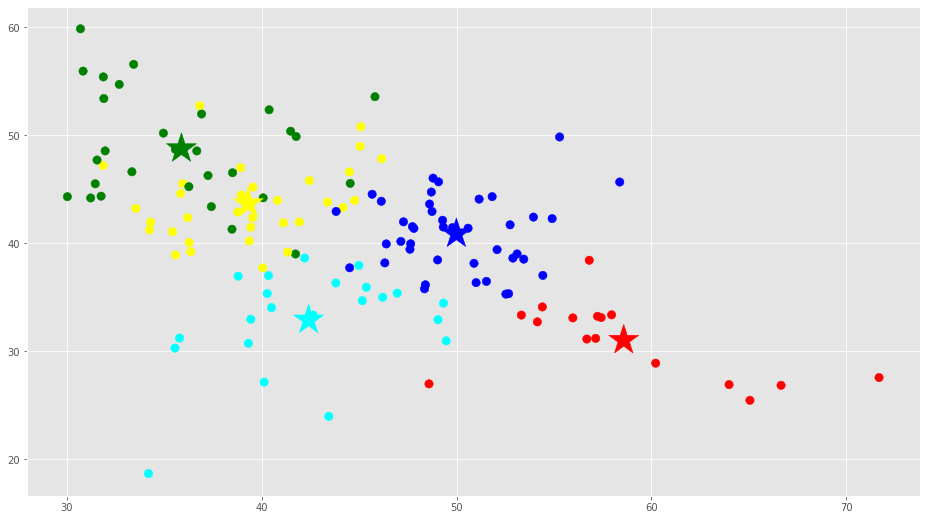

In [13]:
#Se tienen/generan 3 gráficas en 2 dimensiones con las proyecciones a partir de nuestra gráfica 3D 
# para que nos ayude a visualizar los grupos y su clasificación

#GRAFICA 1
# Getting the values and plotting it
f1 = dataframe['op'].values
f2 = dataframe['ex'].values

plt.scatter(f1, f2, c=asignar, s=70)
plt.scatter(C[:, 0], C[:, 1], marker='*', c=colores, s=1000)
plt.show()

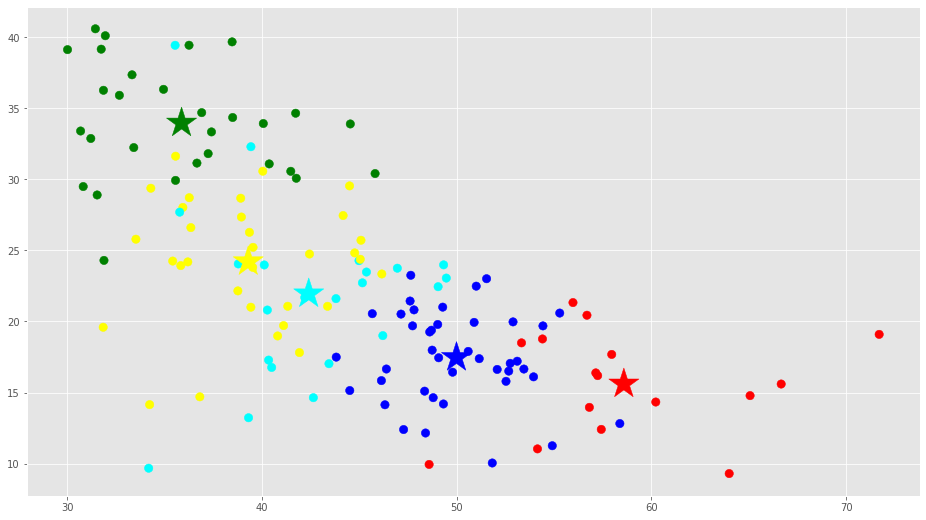

In [14]:
#GRAFICA 2
# Getting the values and plotting it
f1 = dataframe['op'].values
f2 = dataframe['ag'].values
 
plt.scatter(f1, f2, c=asignar, s=70)
plt.scatter(C[:, 0], C[:, 2], marker='*', c=colores, s=1000)
plt.show()

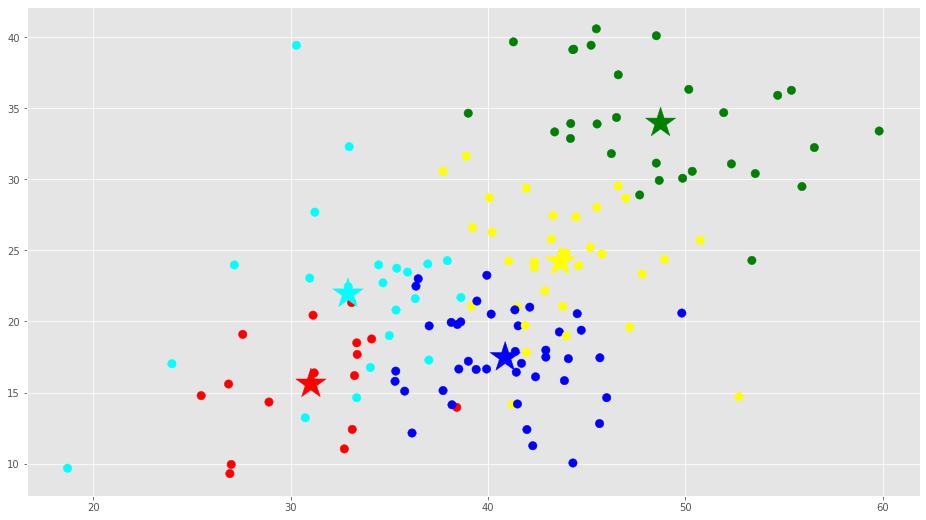

In [15]:
#GRAFICA 3
f1 = dataframe['ex'].values
f2 = dataframe['ag'].values
 
plt.scatter(f1, f2, c=asignar, s=70)
plt.scatter(C[:, 1], C[:, 2], marker='*', c=colores, s=1000)
plt.show()

#Se puede observar que están bastante bien diferenciados los grupos.

In [16]:
#Ahora bien, podemos ver cada uno de los clusters cuántos usuarios tiene:
copy =  pd.DataFrame()
copy['usuario']=dataframe['usuario'].values
copy['categoria']=dataframe['categoria'].values
copy['label'] = labels;
cantidadGrupo =  pd.DataFrame()
cantidadGrupo['color']=colores
cantidadGrupo['cantidad']=copy.groupby('label').size()
cantidadGrupo

,color,cantidad
0,red,16
1,green,29
2,blue,41
3,cyan,22
4,yellow,32


In [17]:
#De igual manera podemos ver la diversidad en rubros laborales de cada uno.
#Por ejemplo en el grupo 0 (rojo), vemos que hay de todas las actividades laborales aunque predominan
# de actividad 1 y 2 correspondiente a Actores y Cantantes con 11 y 15 famosos
group_referrer_index = copy['label'] ==0
group_referrals = copy[group_referrer_index]

diversidadGrupo =  pd.DataFrame()
diversidadGrupo['categoria']=[0,1,2,3,4,5,6,7,8,9]
diversidadGrupo['cantidad']=group_referrals.groupby('categoria').size()
diversidadGrupo

#De categoría 3 “modelos” hay 6 sobre un total de 9.

,categoria,cantidad
0,0,NaN
1,1,5.0
2,2,9.0
3,3,1.0
4,4,1.0
5,5,NaN
6,6,NaN
7,7,NaN
8,8,NaN
9,9,NaN


In [18]:
#Buscaremos los usuarios que están más cerca a los centroids de cada grupo que podríamos decir que
# tienen los rasgos de personalidad característicos que representan a cada cluster:

#vemos el representante del grupo, el usuario cercano a su centroid
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X)
closest

#El resultado de la consulta muestra la posicion en el array de usuarios

array([ 82,  35,  21, 120,  64])

In [19]:
#En este caso podemos ver que en los centros tenemos una modelo,
# un político, presentadora de Tv, locutor de Radio y un deportista.

users=dataframe['usuario'].values
for row in closest:
    print(users[row])

JudgeJudy
DaniMateoAgain
carmenelectra
SarahPalinUSA
ierrejon


In [20]:
#Clasificar nuevas muestras
#Finalmente podemos agrupar y etiquetar nuevos usuarios twitter con sus características y clasificarlos.
X_new = np.array([[45.92,57.74,15.66]]) #davidguetta

new_labels = kmeans.predict(X_new)
print(new_labels)

#Vemos el ejemplo con el usuario de David Guetta y nos devuelve que pertenece al grupo 1 (verde).

[2]


## Conclusiones

<p>El algoritmo de Clustering K-means es uno de los más usados para encontrar grupos ocultos, o sospechados en teoría sobre un conjunto de datos no etiquetado. Esto puede servir para confirmar -o desterrar- alguna teoría que teníamos asumida de nuestros datos o negocio. Y también puede ayudarnos a descubrir relaciones asombrosas entre conjuntos de datos, que de manera manual, no hubiéramos reconocido. Una vez que el algoritmo ha ejecutado y obtenido las etiquetas, será fácil clasificar nuevos valores o muestras entre los grupos obtenidos.</p>

<p>Algunos casos de uso son:</p>
<ul>
    <li>Segmentación por Comportamiento: relacionar el carrito de compras de un usuario, sus tiempos de acción e información del perfil.</li>
    <li>Categorización de Inventario: agrupar productos por actividad en sus ventas</li>
    <li>Detectar anomalías o actividades sospechosas: según el comportamiento en una web reconocer un troll -o un bot- de un usuario normal</li>
</ul>

<p>Atención: Puede haber casos en los que <b>no existan grupos naturales</b>, o clusters que contengan una verdadera razón de ser. Si bien K-means siempre nos brindará “k clusters”, quedará en nuestro criterio reconocer la utilidad de los mismos o bien revisar nuestras features y descartar las que no sirven o conseguir nuevas. También tener en cuenta que en este ejemplo estamos utilizando como medida de similitud entre features la distancia Euclideana pero podemos utilizar otras diversas funciones que podrían arrojar mejores resultados (como Manhattan, Lavenshtein, Mahalanobis, etc).</p>


1. Separe el conjunto de datos en dos porciones: un 70% para entrenamiento y un 30% para prueba. Puede hacer uso de: `from sklearn.model_selection import train_test_split.`

In [21]:
from sklearn.model_selection import train_test_split

# División del conjunto de datos

X_train, X_test, y_train, y_test = train_test_split(dataframe[['op', 'co', 'ex', 'ag', 'ne', 'wordcount']], dataframe.categoria, random_state=1)

print('Completo: ', dataframe.shape[0])
print('Entrenamiento: ', X_train.shape[0])
print('Prueba: ', X_test.shape[0])

Completo:  140
Entrenamiento:  105
Prueba:  35


2. Con los datos obtenidos de entrenamiento del conjunto de datos, ejecute el algoritmo de K-Means. Haga un análisis y explique a partir del Método del codo la selección del número correcto de clusters (k) para la ejecución del algoritmo K-Means.

Vamos a comenzar creando la gráfica de codo mediante la libreria `KElbowVisualizer`:

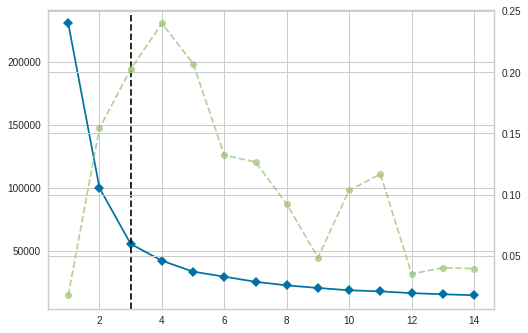

In [27]:
# Gráfica de codo.
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer

vis = KElbowVisualizer(KMeans(), k = (1,15))
vis.fit(X_train)
plt.show()

La libreria elige de forma automatica la reducción más util. El valor de k a apartir del cual la curva se vuelve más suave es k = 3, así que este será el valor que usaremos.

In [23]:
# Importamos la libreria de sklearn
from sklearn.cluster import KMeans

km = KMeans(n_clusters = 3)
# La mayoria de las veces lo que se hace para determinar un hiperparámetroes jugar
# En este caso elegimos tres

# Entrenamos
km = km.fit(X_train)
# Predecimos
y_hat = km.predict(X_train)
C = km.cluster_centers_

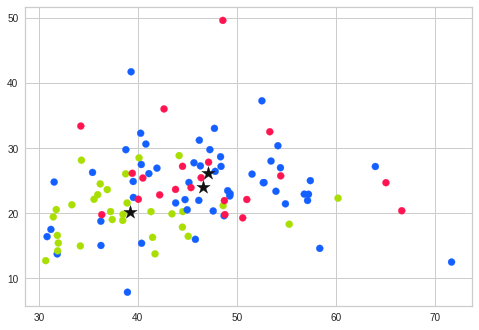

In [24]:
# Visualicemos sobre 2 dimensiones únicamente.

import matplotlib
fig, ax = plt.subplots()

colors = ['#FF1451', '#145FFF', '#A8DE00']

ax.scatter(X_train.iloc[:,0], X_train.iloc[:,1], c = y_hat, cmap=matplotlib.colors.ListedColormap(colors))
ax.scatter(C[:,0], C[:,1], marker = '*', s = 200, c = 'k')

3. Trate el conjunto de datos de prueba como nuevas muestras para clasificar; por lo que usando el algoritmo de K-vecinos, atendiendo a los resultados obtenidos anteriormente con K-Means, agrupe y etiquete dichos nuevos usuarios twitter con sus características y clasifíquelos.

In [35]:
from sklearn.neighbors import KNeighborsClassifier

knei = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)

In [36]:
#Entreno el modelo
knei.fit(X_train, y_hat)

KNeighborsClassifier()

In [37]:
#Predicción
y_pred = knei.predict(X_test)

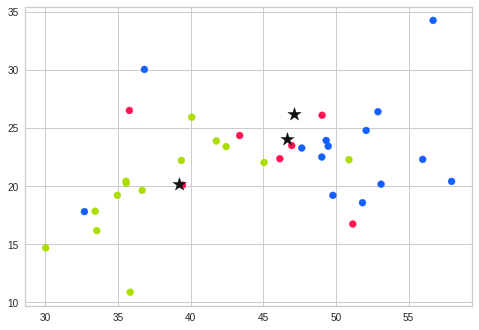

In [38]:
fig, ax = plt.subplots()

colors = ['#FF1451', '#145FFF', '#A8DE00']

ax.scatter(X_test.iloc[:,0], X_test.iloc[:,1], c = y_pred, cmap=matplotlib.colors.ListedColormap(colors))
ax.scatter(C[:,0], C[:,1], marker = '*', s = 200, c = 'k')